In [1]:
# Which public health factors have the greatest impact on life expectancy by country

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plot_module as plm


In [21]:
df = pd.read_csv('refined_life_expectancy.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

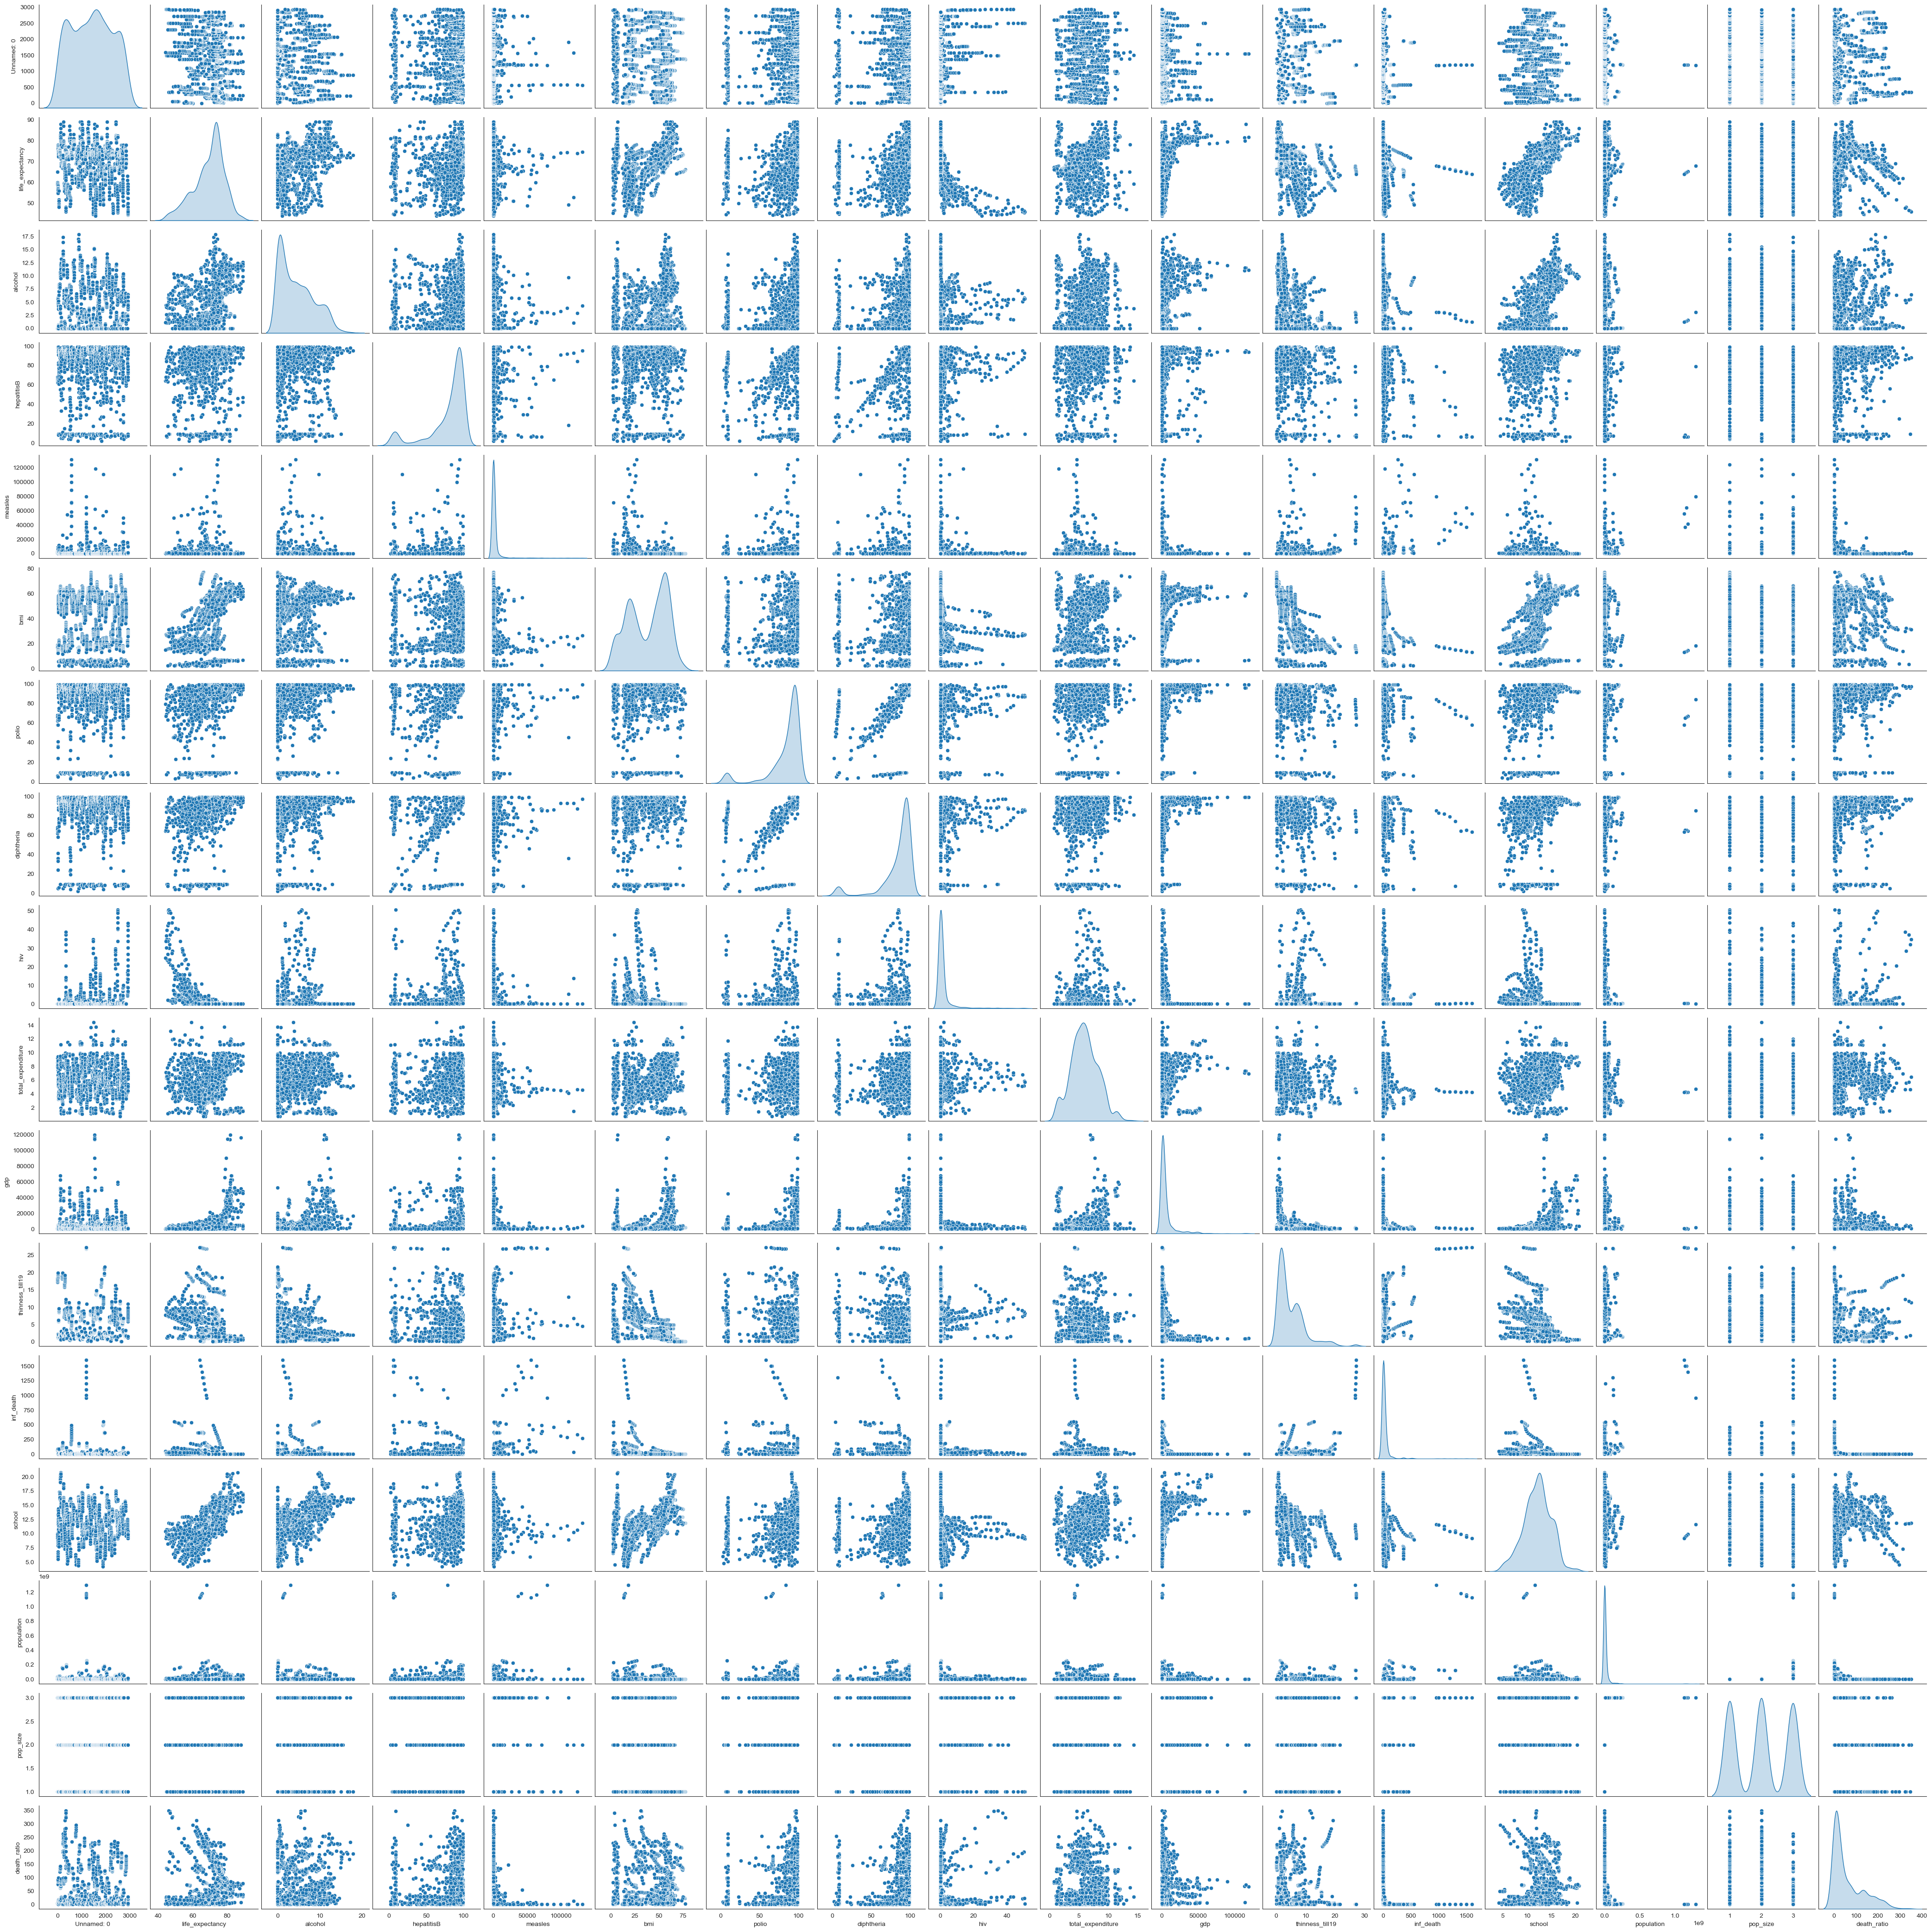

In [22]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)
# plt.savefig('pairedplots_all.png')

In [23]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# children malnutrition, average education, country size (small/medium/big), 
# the ratio between adult to infant mortality, the interactions between bmi+alcohol (lifestyle), 
# and the interaction between population+gdp might effect the life expectancy

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
# corr_map

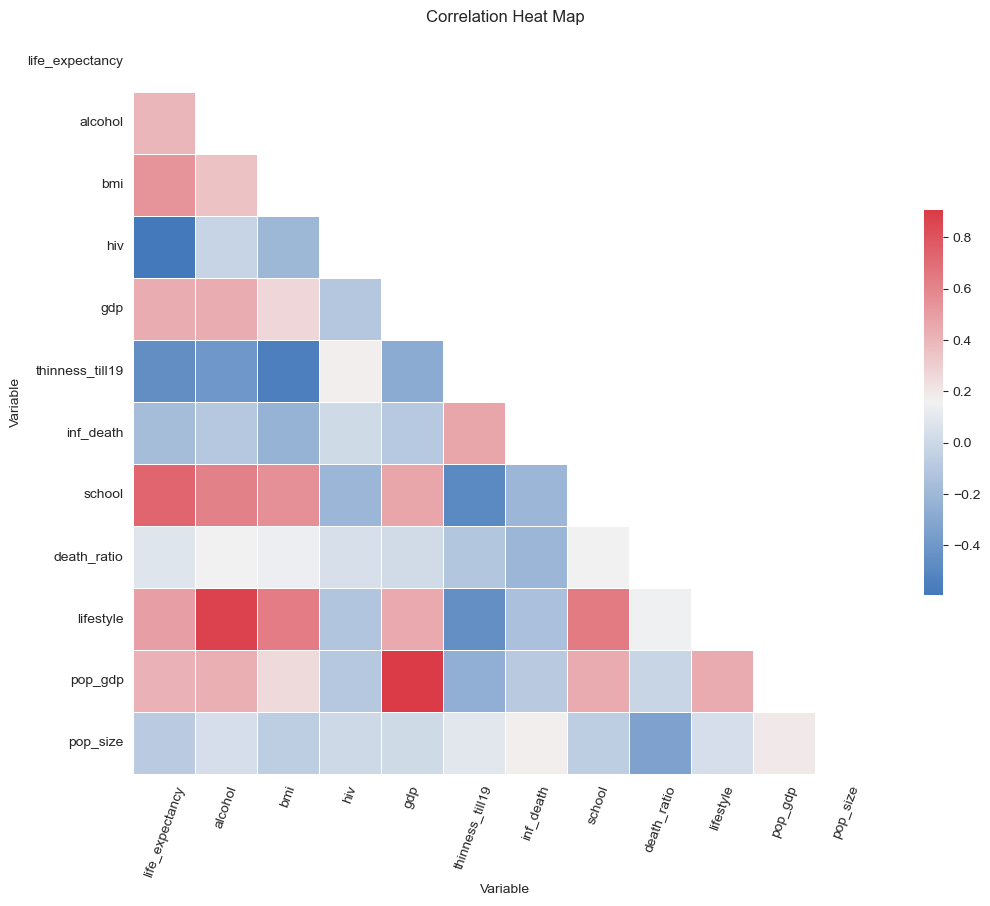

In [24]:
# Create a heatmap for all our variables
plm.CorrMtx(corr_map)

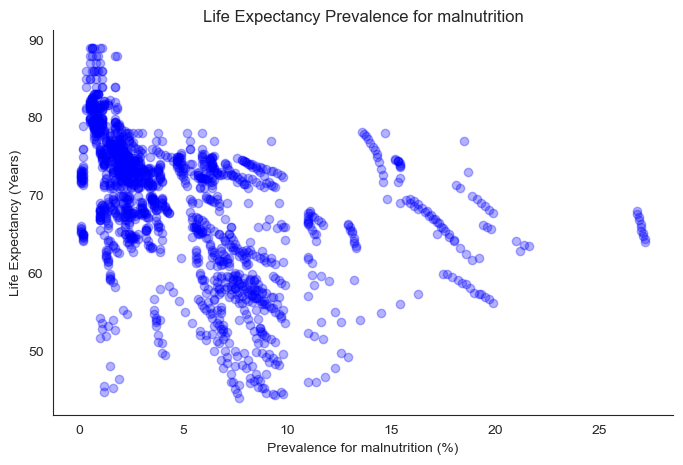

In [25]:
# Example 1: Correlation between average education and life expectancy
plm.create_scatter(new_df['thinness_till19'], new_df['life_expectancy'], 'Life Expectancy Prevalence for malnutrition', 
                          'Prevalence for malnutrition (%)', 'Life Expectancy (Years)')         
# np.corrcoef(new_df['school'], new_df['life_expectancy'])

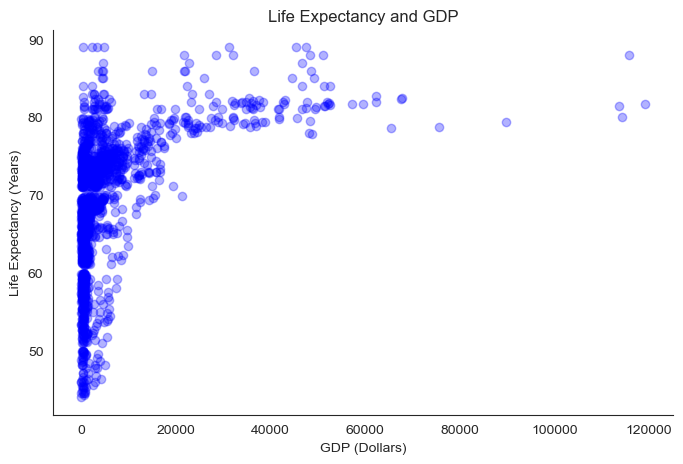

In [26]:
# Example 2: Correlation between GDP and life expectancy
plm.create_scatter(new_df['gdp'], new_df['life_expectancy'], 'Life Expectancy and GDP', 
                                         'GDP (Dollars)', 'Life Expectancy (Years)')         

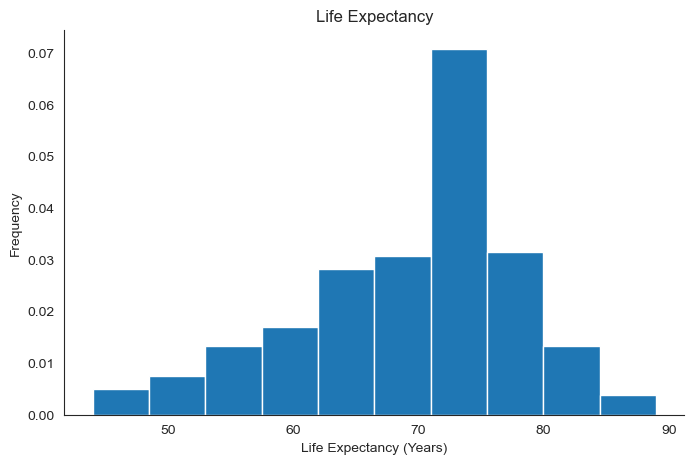

In [27]:
plm.create_hist(new_df['life_expectancy'], transform='None', title="Life Expectancy", xlabel="Life Expectancy (Years)")
# plt.savefig('gdp_hist_after.png')

(1649, 12)

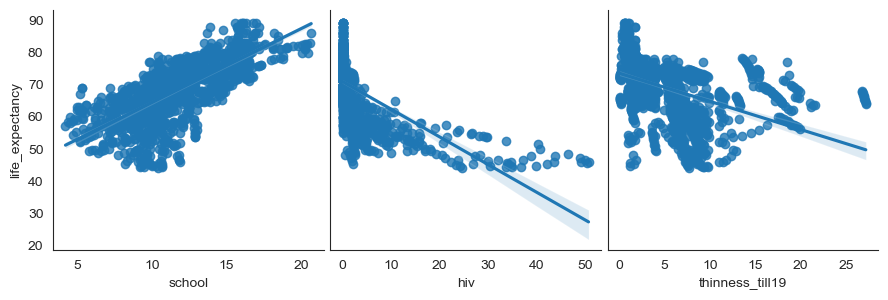

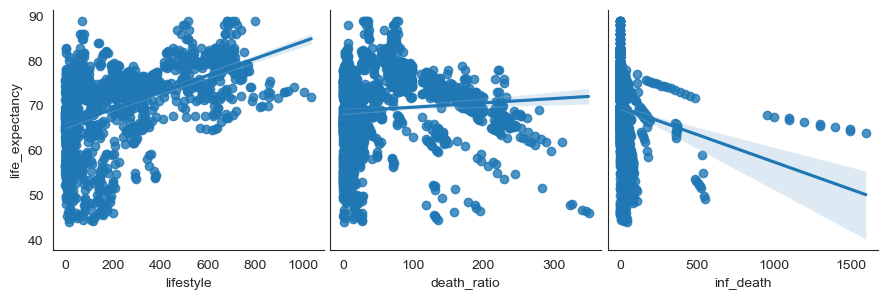

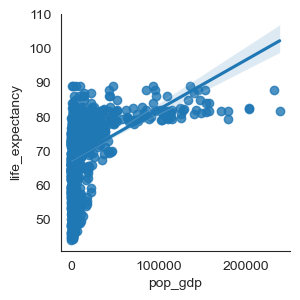

In [28]:
# before running the model we looked at our features more closely to check for outliers
depended = ['life_expectancy']
features = ['school', 'hiv', 'thinness_till19', 'lifestyle',
            'death_ratio', 'inf_death', 'pop_gdp'] 

# looking at our data again to try and locate outliers
plm.get_pairs(new_df, depended, features, 3)
new_df.shape

(1632, 12)

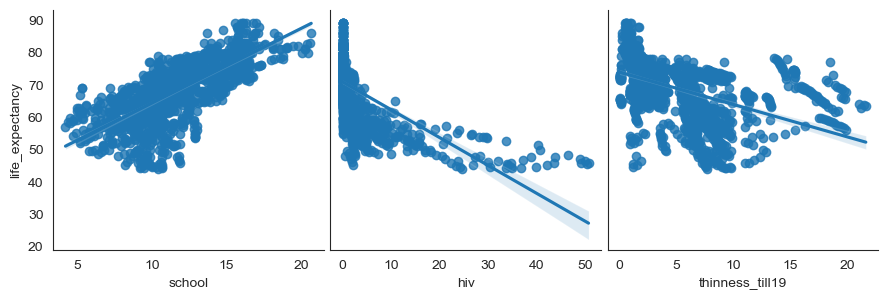

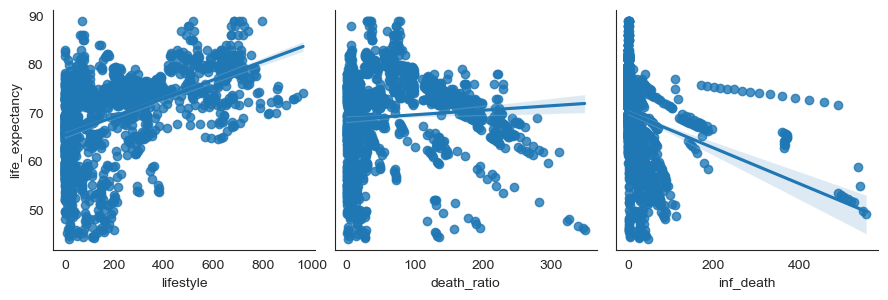

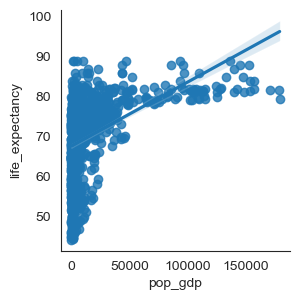

In [29]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.pop_gdp < 190000] 
new_df = new_df[new_df.thinness_till19 < 25]
new_df = new_df[new_df.lifestyle < 1000]

plm.get_pairs(new_df, depended, features, 3)
new_df.shape

In [30]:
# transform our independent variables to achieve a more linear relationship and normal distribution
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\betha\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

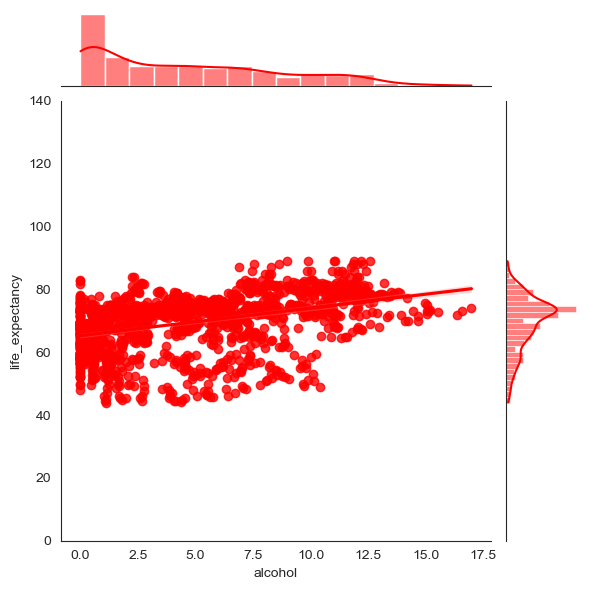

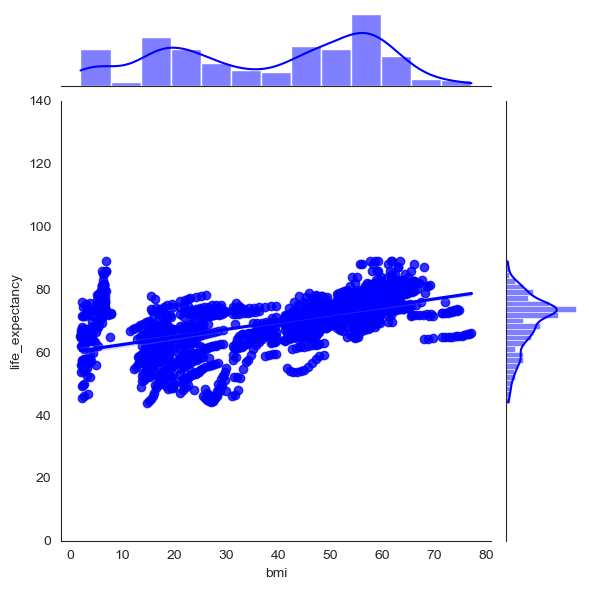

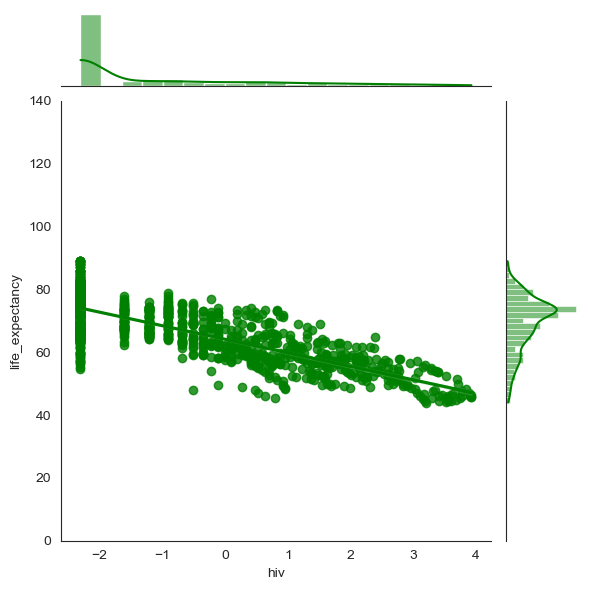

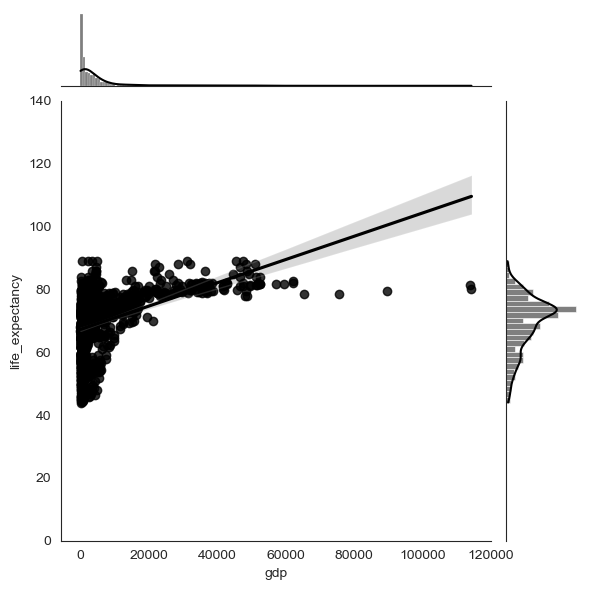

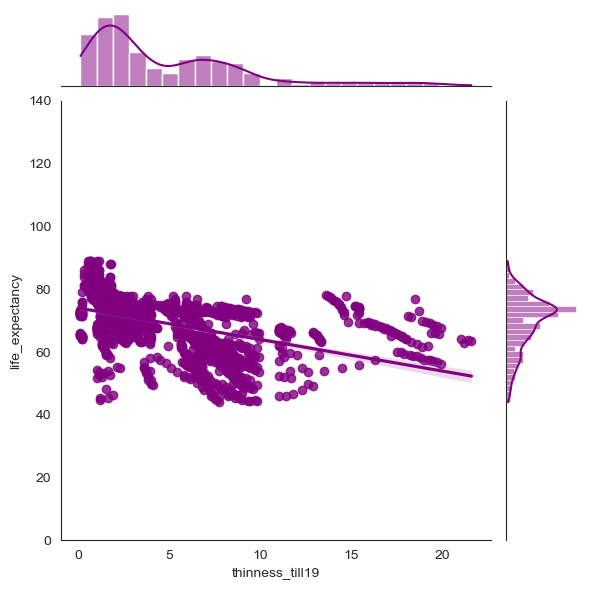

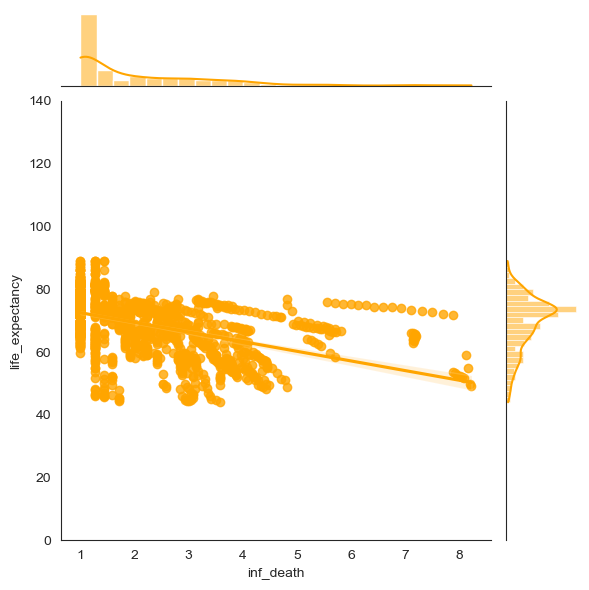

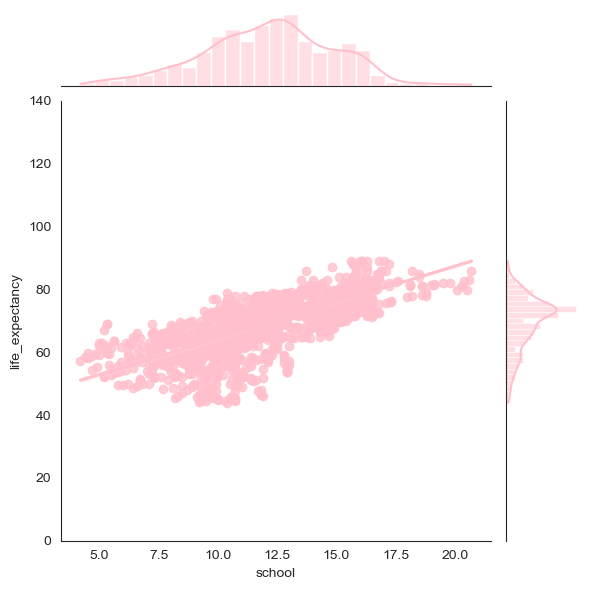

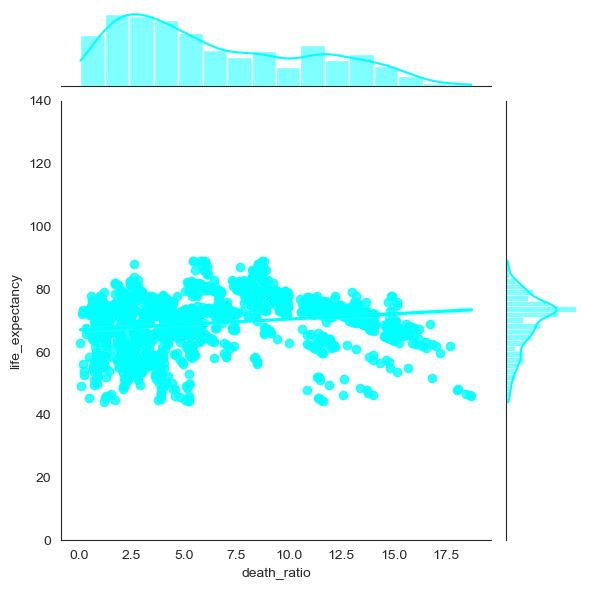

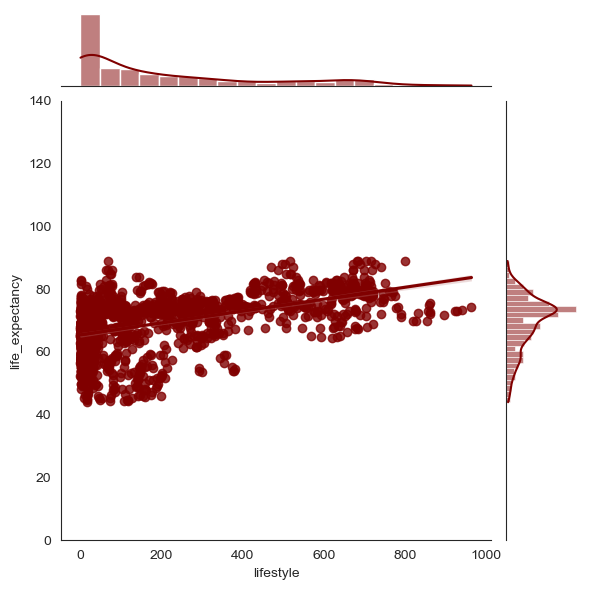

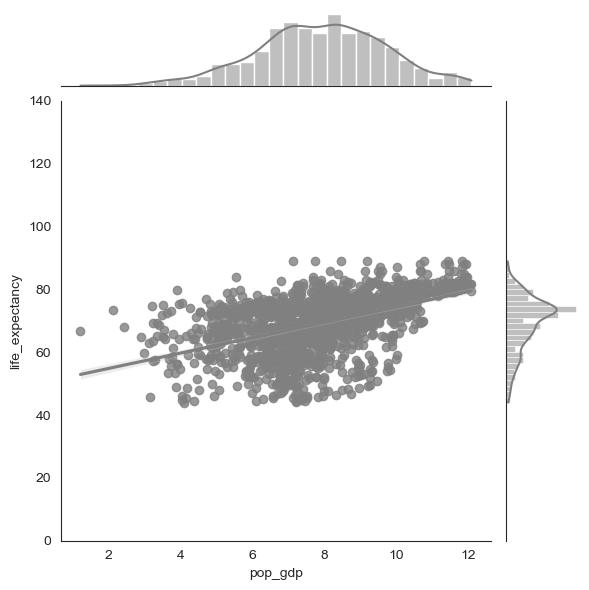

In [32]:
# Using seaborn to create scatters and distribution graphs to get a final look at our predictors before modeling 
colors = ['red','blue','green','black','purple','orange','pink', 'cyan','maroon', 'gray']
count = 0 
for column in new_df.columns[1:-1]:
    plots = sns.jointplot(x=column, y='life_expectancy', data=new_df, kind='reg', ylim=(0,140), color=colors[count])
    #plots.annotate(stats.pearsonr)
    count += 1

In [33]:
# first model to test our feature's significance
lr_model_init = ols(formula='life_expectancy~bmi+hiv+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model_init.summary()

# save summary
# plt.rc('figure', figsize=(12, 7))
# plt.text(0.01, 0.05, str(lr_model_init.summary()), {'fontsize': 10}, fontproperties = 'monospace')
# plt.tight_layout()
# plt.savefig('init_summary.png')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     663.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:39:16   Log-Likelihood:                -4537.1
No. Observations:                1632   AIC:                             9096.
Df Residuals:                    1621   BIC:                             9156.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           55.4397      0.906     61.224      0.000      53.664      57.216
C(pop_size)[T.2]    -0.7259      0.243     -2.985      0.003      -1.203      -0.249
C(pop_size)[T.3]    -0.4518      0.275     -1.642      0.101      -0.992       0.088
bmi                 -0.0006      0.007     -0.080      0.936      -0.015       0.014
hiv                 -2.9871      0.072    -41.508      0.000      -3.128      -2.846
thinness_till19     -0.1342      0.029     -4.611      0.000      -0.191      -0.077
inf_death           -1.0295      0.114     -9.035      0.000      -1.253      -0.806
school               0.8643      0.058     14.980      0.000       0.751       0.977
death_ratio         -0.2095      0.031     -6.829      0.000      -0.270      -0.149
lifestyle            0.0015      0.001      2.404      0.016       0.000       0.003
pop_gdp              0.5083      0.071      7.183      0.000       0.369       0.647
==============================================================================
Omnibus:                       12.052   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.465
Skew:                          -0.064   Prob(JB):                     0.000266
Kurtosis:                       3.475   Cond. No.                     2.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
#adjusting the model - remove features that were not statistically significant (pop_size)
lr_model_inter = ols(formula='life_expectancy~pop_gdp+lifestyle+hiv+thinness_till19+inf_death+school+death_ratio', data=new_df).fit()
lr_model_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     943.7
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:39:21   Log-Likelihood:                -4541.6
No. Observations:                1632   AIC:                             9099.
Df Residuals:                    1624   BIC:                             9142.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          55.2425      0.849     65.062      0.000      53.577      56.908
pop_gdp             0.4664      0.068      6.881      0.000       0.333       0.599
lifestyle           0.0014      0.001      2.453      0.014       0.000       0.003
hiv                -3.0036      0.070    -42.955      0.000      -3.141      -2.866
thinness_till19    -0.1376      0.028     -4.942      0.000      -0.192      -0.083
inf_death          -1.0475      0.111     -9.437      0.000      -1.265      -0.830
school              0.8756      0.058     15.202      0.000       0.763       0.989
death_ratio        -0.2047      0.030     -6.825      0.000      -0.263      -0.146
==============================================================================
Omnibus:                       12.601   Durbin-Watson:                   0.438
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.182
Skew:                          -0.073   Prob(JB):                     0.000186
Kurtosis:                       3.481   Cond. No.                     2.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

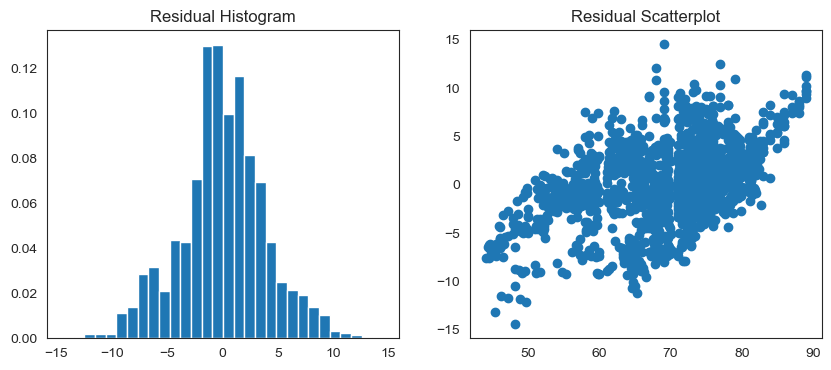

In [35]:
# testing residuals
plm.checkresiduals(new_df, 'life_expectancy', lr_model_inter)

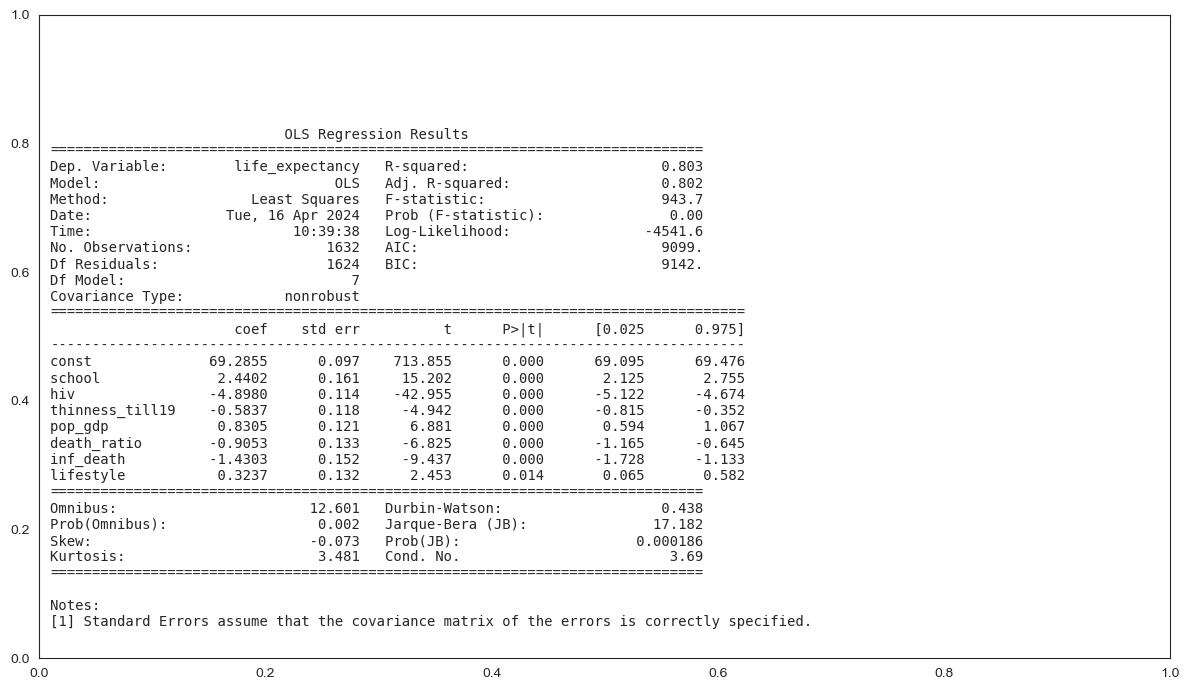

In [36]:
# Scaling the data set
independent = ['school', 'hiv', 'thinness_till19', 'pop_gdp',
               'death_ratio', 'inf_death', 'lifestyle'] 

scaler = StandardScaler()
scaler.fit(new_df[independent])
scaled_features = scaler.transform(new_df[independent])

# create a scaled dataframe
scaled_features_df = pd.DataFrame(scaled_features, columns=independent, index=new_df.index)
scaled_features_df.head()

# running the model again
scaled_features_model = sm.OLS(endog=new_df['life_expectancy'], exog=sm.add_constant(scaled_features_df)).fit()
scaled_features_model.summary()

# save summary
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(scaled_features_model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.tight_layout()
# plt.savefig('init_summary.png')

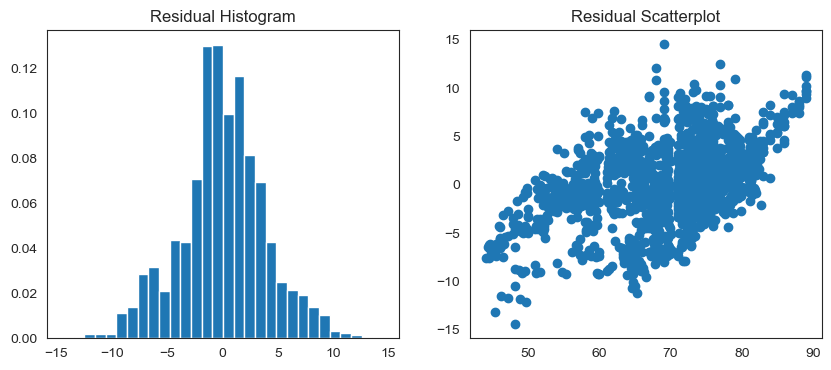

In [37]:
# check residuals
plm.checkresiduals(new_df, 'life_expectancy', scaled_features_model)

Mean absolute error: 3.0221109597775038
Mean squared error: 14.933635293524443
Root squared error: 3.8644062019312155


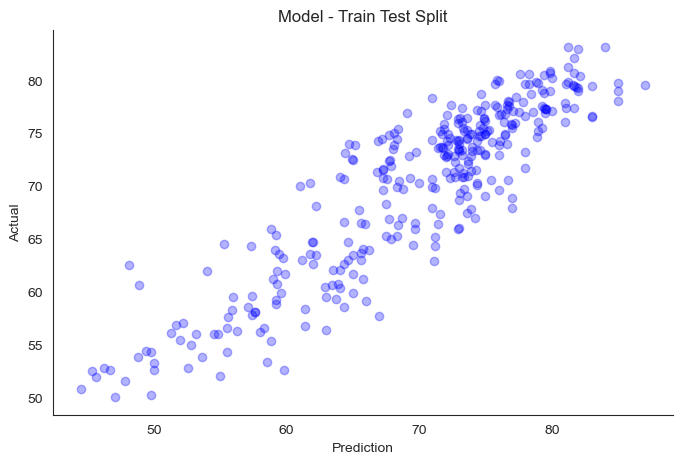

In [38]:
# test train split
X = new_df[['hiv','lifestyle', 'death_ratio','school', 'thinness_till19', 'inf_death', 'pop_gdp']].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)
# print(model.intercept_)
# print(model.coef_)

y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'Actual': y_test.flatten(), 'Prediction': y_predict.flatten()})
plot_df = predict_df

plm.create_scatter(plot_df.Actual, plot_df.Prediction, 'Model - Train Test Split', 'Prediction', 'Actual')
# plt.savefig('model_final.png')

print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('Root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

Mean absolute error: 2.9952137430519903
Mean squared error: 14.730582365132545
Moot squared error: 3.838044080665638


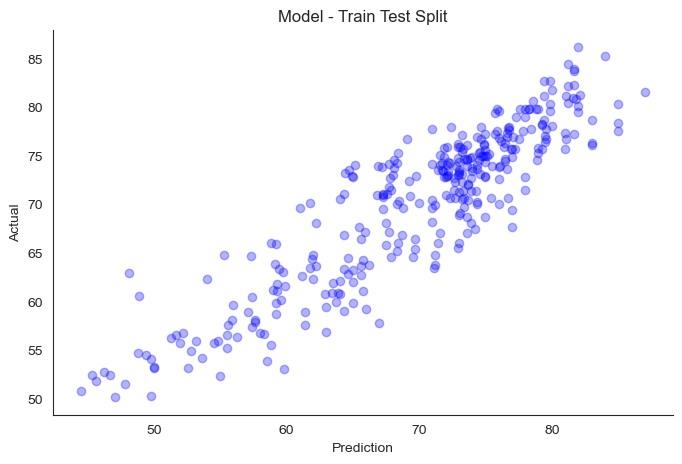

In [39]:
# adding all the features that were considered insignificant
X2 = new_df[['lifestyle','bmi', 'pop_size', 'hiv','pop_gdp', 'alcohol', 'death_ratio','school', 'thinness_till19', 'inf_death', 'gdp']].values
y2 = new_df.life_expectancy.values.reshape(-1,1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train2, y_train2)
# print(model.intercept_)
# print(model.coef_)

y_predict2 = model.predict(x_test2)
predict_df2 = pd.DataFrame({'Prediction': y_predict2.flatten(), 'Actual': y_test2.flatten()})
plot_df2 = predict_df2

# show the difference between the actual and the predctions
plm.create_scatter(plot_df2.Actual, plot_df2.Prediction, 'Model - Train Test Split', 'Prediction', 'Actual')
# plt.savefig('model_all.png')


print('Mean absolute error:', metrics.mean_absolute_error(y_test2, y_predict2))
print('Mean squared error:', metrics.mean_squared_error(y_test2, y_predict2))
print('Moot squared error:', np.sqrt(metrics.mean_squared_error(y_test2, y_predict2)))